In [6]:
import os
import sys
import numpy as np

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"]="7"

sys.path.append('/path/to/pommerman/playground/')
sys.path.append('/path/to/evaluation_utils.py/')

In [3]:
from copy import deepcopy
from pommerman.agents import SimpleAgent
from pommerman.configs import ffa_competition_env
from pommerman.constants import BOARD_SIZE
from pommerman.envs.v0 import Pomme
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

In [79]:
initial_rollouts   = 600
min_episode_length = 35 

train_data_path    = './dataset/'
train_data_obs     = os.path.join(train_data_path, 'obs.npy')
train_data_labels  = os.path.join(train_data_path, 'labels.npy')
train_data_reward  = os.path.join(train_data_path, 'reward.npy')
train_data_obs_map = os.path.join(train_data_path, 'obs_map.npy')
train_data_obs_map_history = os.path.join(train_data_path, 'obs_map_history.npy')

if not os.path.isdir(train_data_path):
    os.makedirs(train_data_path)

In [5]:
class Episode:   
    def __init__(self, agent_id, episode_id):
        self.agent_id = agent_id
        self.episode_id = episode_id
        self.observations = []
        self.actions = []
        self.reward = []
        self.done = False        
        
    def record(self, obs, action, reward):
        self.observations.append(deepcopy(obs))
        self.actions.append(deepcopy(action))
        # Agent not win or not die
        if reward != 0:
            self.done = True
            self.reward = [reward] * self.get_num_steps()
        
    def get_num_steps(self):
        return len(self.observations)        

In [7]:
# Environment wrapper
class Stimulator:
    def __init__(self, env):
        self.env = env
        self.episodes = []
        
    def record(self, agents, obs, actions, rewards):        
        for agent_id in range(len(agents)): 
            agent = agents[agent_id]
            # If an agent is dead (or win) we should not record a history
            if not agent.done:    
                agent.record(obs[agent_id], actions[agent_id], rewards[agent_id])

    def stimulate(self, num_rollouts):
        for cur_episode in tqdm(range(num_rollouts)):
            # Create a history for each agent
            agents = []                
            for agent_id in range(4):
                agents.append(Episode(agent_id, cur_episode))            
            
            done = False     
            # Obtain initial observations
            obs = self.env.reset()
            try:
                while not done:
                    # FUCK self.env.act change "POSITION"!!!!
                    obs_to_save = deepcopy(obs)                    
                    # Produce actions
                    actions = self.env.act(obs)
                    # Make an episode step. Save an observations as new_obs, because we want to record previous one
                    obs, rewards, done, _ = self.env.step(actions)
                    # Record observations and actions
                    self.record(agents, obs_to_save, actions, rewards)                    
            except:
                print("Error occurs")
                continue            
            self.episodes.extend(agents)
    
    def get_episodes(self):
        return deepcopy(self.episodes)

In [8]:
# Instantiate the environment
config = ffa_competition_env()
env = Pomme(**config["env_kwargs"])

# Random seed
env.seed(0)

# Add agents
agents = [SimpleAgent(config["agent"](agent_id, config["game_type"])) for agent_id in range(4)]
env.set_agents(agents)
env.set_init_game_state(None)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [9]:
# Generate training data
stimulator = Stimulator(env)
stimulator.stimulate(initial_rollouts)

In [12]:
for episode in tqdm(stimulator.episodes):
    for observation in episode.observations:
        board = observation['board']
        pos   = observation['position']    
        if board[pos[0], pos[1]] != (episode.agent_id + 10):
            print("ERROR")

## Win/Lose in corners

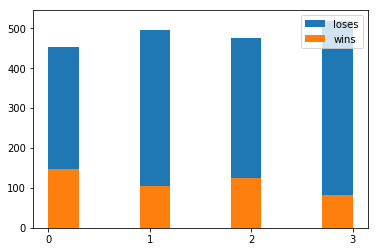

In [16]:
wins = []
loses = []

for episode in stimulator.episodes:
    if episode.reward[-1] == -1:
        loses.append(episode.agent_id)
    elif episode.reward[-1] == 1:
        wins.append(episode.agent_id)
    else:
        print("FUCK")

plt.hist(loses, label='loses')
plt.hist(wins, label='wins')
plt.xticks(np.arange(4))
plt.legend()
plt.show()

In [17]:
np.bincount(loses)

array([452, 496, 476, 519])

## Episode length

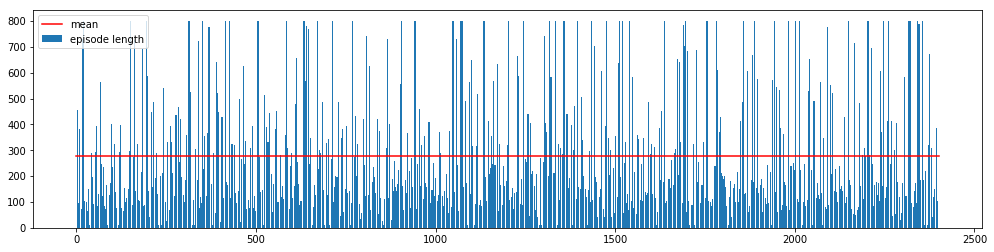

In [19]:
episode_length = [episode.get_num_steps() for episode in stimulator.episodes]
    
plt.figure(figsize=(17,4))
plt.bar(range(0, len(episode_length)), episode_length)
plt.plot([0, len(episode_length)], [np.mean(episode_length), np.mean(episode_length)], 'r')
plt.legend(['mean', 'episode length'])
plt.show()

In [22]:
np.min(episode_length), np.max(episode_length), np.sum(np.array(episode_length) < min_episode_length)

(10, 801, 151)

## Rewards

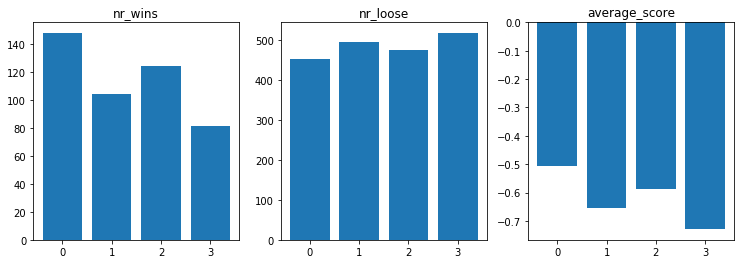

In [23]:
nr_wins = [0] * 4
nr_loose = [0] * 4
nr_tie = [0] * 4
average_score = [[], [], [], []]

for episode in stimulator.episodes:
    if episode.reward[-1] == 1:
        nr_wins[episode.agent_id] += 1
    else:
        nr_loose[episode.agent_id] += 1
    average_score[episode.agent_id].append(episode.reward[-1])
average_score[0] = np.mean(average_score[0])
average_score[1] = np.mean(average_score[1])
average_score[2] = np.mean(average_score[2])
average_score[3] = np.mean(average_score[3])

plt.figure(figsize=(17,4))
plt.subplot(141)
plt.bar(range(0,4), nr_wins)
plt.title('nr_wins')
plt.subplot(142)
plt.bar(range(0,4), nr_loose)
plt.title('nr_loose')
plt.subplot(143)
plt.bar(range(0,4), average_score)
plt.title('average_score')
plt.show()

## Consequtive actions

In [24]:
actions_length = []
for episode in stimulator.episodes:
    current_action = episode.actions[0]
    action_length = 0
    for action in episode.actions:
        if current_action != action:
            actions_length.append(action_length)            
            current_action = action
            action_length = 0
        action_length += 1

In [25]:
np.mean(actions_length), np.median(actions_length), np.max(actions_length)

(1.6890224514546033, 1.0, 515)

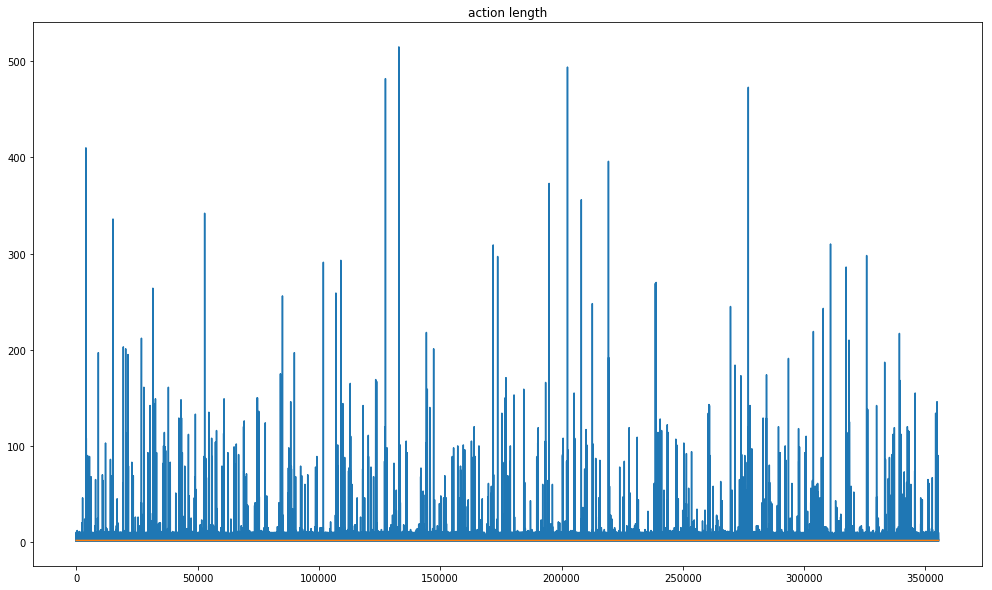

In [26]:
plt.figure(figsize=(17,10))
plt.plot(actions_length)
plt.plot([np.mean(actions_length)] * len(actions_length))
plt.title('action length')
plt.show()

## Actions frequency

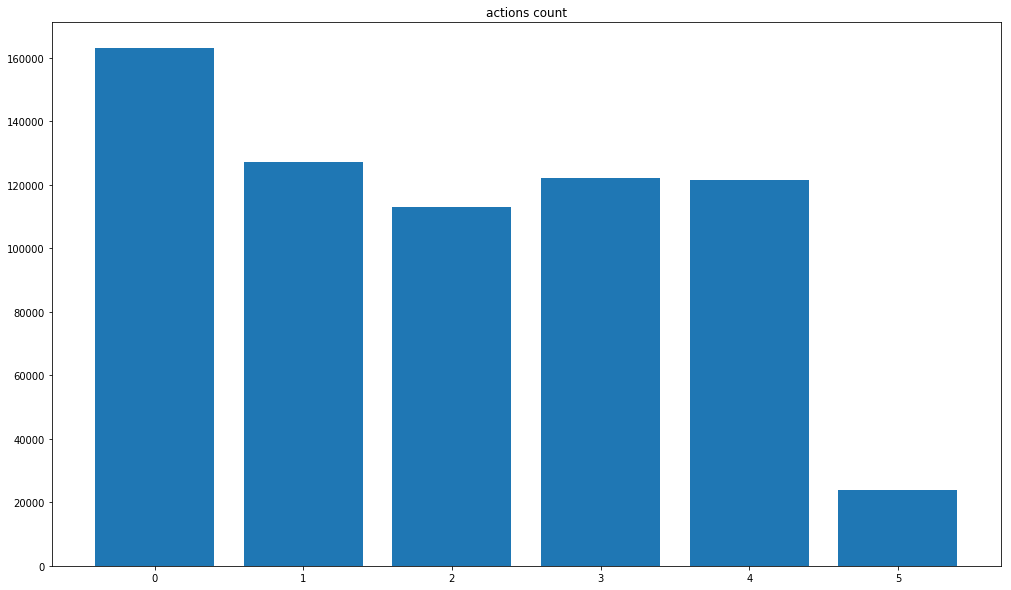

In [27]:
actions_count = np.zeros(6)
for episode in stimulator.episodes:    
    for action in episode.actions:
        actions_count[action] += 1
        
plt.figure(figsize=(17,10))
plt.bar(range(0,6), actions_count)
plt.title('actions count')
plt.show()

# Some data preprocessing

Remove episodes with too small length. Maybe it is suicide.

In [28]:
episodes = [episode for episode in stimulator.episodes if episode.get_num_steps() > min_episode_length or episode.reward[-1] == 1]
len(episodes)

2251

Let's remove consequtive actions. I will use threshold 12.

In [22]:
threshold = 12

for episode in tqdm(episodes):
    # New observations
    obs = []
    act = []
    rew = []
    
    # Initial values
    cur_action = episode.actions[0]
    seq_length = 0
    for ind in range(len(episode.actions)):
        # Current action
        action = episode.actions[ind]
        
        # If an action the same
        if action == cur_action:
            seq_length += 1
        else:
            seq_length = 0
            cur_action = action
        # If a sequence is less than threashold
        if seq_length <= threshold:
            obs.append(episode.observations[ind])
            act.append(episode.actions[ind])
            rew.append(episode.reward[ind])
    
    # Save preprocessed observations
    episode.actions      = act
    episode.observations = obs
    episode.reward       = rew

Let's rerun plots.

## Save stuff

In [33]:
observations = []
actions = []
rewards = []
for episode in stimulator.episodes:
    observations.append(episode.observations)
    actions.append(episode.actions)
    rewards.append(episode.reward)

observations_merged = np.concatenate(observations)
actions_merged = np.concatenate(actions)
rewards_merged = np.concatenate(rewards)

In [30]:
np.save(train_data_obs, observations_merged)
np.save(train_data_labels, actions_merged)
np.save(train_data_reward, rewards_merged)

In [ ]:
observations_merged = np.load(train_data_obs)
actions_merged      = np.load(train_data_labels)
rewards_merged      = np.load(train_data_reward)

In [34]:
observations_merged.shape, actions_merged.shape, rewards_merged.shape

((670725,), (670725,), (670725,))

In [41]:
observations_merged[0]

{'alive': [10, 11, 12, 13],
 'ammo': 1,
 'blast_strength': 2,
 'board': array([[ 0,  0,  0,  2,  1,  1,  1,  0,  0,  1,  2],
        [ 0, 10,  0,  0,  2,  2,  2,  0,  0, 13,  2],
        [ 0,  0,  0,  2,  1,  1,  2,  2,  1,  0,  0],
        [ 2,  0,  2,  0,  0,  2,  1,  2,  1,  0,  2],
        [ 1,  2,  1,  0,  0,  0,  1,  2,  1,  2,  2],
        [ 1,  2,  1,  2,  0,  0,  1,  1,  1,  2,  1],
        [ 1,  2,  2,  1,  1,  1,  0,  1,  1,  2,  2],
        [ 0,  0,  2,  2,  2,  1,  1,  0,  0,  0,  1],
        [ 0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0],
        [ 1, 11,  0,  0,  2,  2,  2,  0,  0, 12,  0],
        [ 2,  2,  0,  2,  2,  1,  2,  1,  0,  0,  0]], dtype=uint8),
 'bomb_blast_strength': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.

## Featurize

In [45]:
def make_centered(board, position, view_size=BOARD_SIZE * 2 - 1, crop=False):
    # If it is a perk channel, just return the resized full array
    if np.all(board == 1):
        return np.full((view_size, view_size, 1), 1)
    
    # make sure of odd view_size
    view_size = view_size + 1 if view_size % 2 == 0 else view_size 
    
    # TODO: what should be the value of the off world? maybe defining an edge channel?
    agent_view = np.zeros((view_size, view_size, 1)) # agent centric full-world coverage
    center = (view_size // 2 + 1, view_size // 2 + 1)
    
    # copy board to the new view
    offset_y = center[0] - position[0] - 1
    offset_x = center[1] - position[1] - 1
    agent_view[offset_y:offset_y+BOARD_SIZE, offset_x:offset_x+BOARD_SIZE, :] = board
    
    # finalize view size
    r = BOARD_SIZE // 2
    start, end = center[0]-r-1, center[0]+r
    if crop:
        agent_view = agent_view[start:end, start:end, :]
    
    return np.array(agent_view, dtype=np.float32)

def featurize(obs, center=True, crop=False):
    shape = (BOARD_SIZE, BOARD_SIZE, 1)

    def get_matrix(board, key):
        res = board[key]
        return res.reshape(shape).astype(np.float32)

    def get_map(board, item):
        map = np.zeros(shape)
        map[board == item] = 1
        return map

    board = get_matrix(obs, 'board')

    path_map       = get_map(board, 0)          # Empty space
    rigid_map      = get_map(board, 1)          # Rigid = 1
    wood_map       = get_map(board, 2)          # Wood = 2
    bomb_map       = get_map(board, 3)          # Bomb = 3
    flames_map     = get_map(board, 4)          # Flames = 4
    fog_map        = get_map(board, 5)          # TODO: not used for first two stages Fog = 5
    extra_bomb_map = get_map(board, 6)          # ExtraBomb = 6
    incr_range_map = get_map(board, 7)          # IncrRange = 7
    kick_map       = get_map(board, 8)          # Kick = 8
    skull_map      = get_map(board, 9)          # Skull = 9

    position = obs["position"]
    my_position = np.zeros(shape)
    my_position[position[0], position[1], 0] = 1

    team_mates = get_map(board, obs["teammate"].value) # TODO during documentation it should be an array

    enemies = np.zeros(shape)
    for enemy in obs["enemies"]:
        enemies[board == enemy.value] = 1

    bomb_blast_strength = get_matrix(obs, 'bomb_blast_strength')
    bomb_life           = get_matrix(obs, 'bomb_life')

    ammo           = np.full((BOARD_SIZE, BOARD_SIZE, 1), obs["ammo"])
    blast_strength = np.full((BOARD_SIZE, BOARD_SIZE, 1), obs["blast_strength"])
    can_kick       = np.full((BOARD_SIZE, BOARD_SIZE, 1), int(obs["can_kick"]))
    
    maps = [my_position, enemies, team_mates, path_map, rigid_map, 
                          wood_map, bomb_map, flames_map, fog_map, extra_bomb_map,
                          incr_range_map, kick_map, skull_map, bomb_blast_strength,
                          bomb_life, ammo, blast_strength, can_kick]
    
    if center:
        maps = [make_centered(m, position, crop=crop) for m in maps]
    
    obs = np.concatenate(maps, axis=2)
    return obs.astype(np.int16)

In [46]:
observations_map = [np.array([featurize(obs, center=True, crop=False) for obs in episode]) for episode in tqdm(observations)]
len(observations_map)

2400

Check that our agent is in the center

In [49]:
observations_map[0][0][:,:,0]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [67]:
observations_map[0][0][:,:,3]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,

## Add previous frames as history

In [68]:
def get_history(observations, i, axis=0):
    if i < 4:
        n_first = 4 - i
        return np.concatenate([np.array([observations[0] for _ in range(n_first)]), np.array(observations[:i]).reshape(i, 21, 21, 18)], axis=0)
    return np.stack(observations[i-4:i], axis)

In [71]:
np.array([get_history(observations_map[0], 0), get_history(observations_map[0], 1)]).shape

(2, 4, 21, 21, 18)

In [72]:
observations_map_history = [np.array([get_history(episode, i) for i in range(len(episode))], dtype=np.uint8) for episode in tqdm(observations_map)]

In [78]:
observations_map_history = np.concatenate(observations_map_history).astype(np.uint8)

In [80]:
observations_map_history.shape

(670725, 4, 21, 21, 18)

In [81]:
np.save(train_data_obs_map_history, observations_map_history)

In [82]:
episode_lengths = np.array([len(episode) for episode in observations])
len(episode_lengths), np.sum(episode_lengths)

(2400, 670725)

In [83]:
np.save('./dataset/episode_lengths.npy', episode_lengths)